<a href="https://colab.research.google.com/github/dmitryglhf/jupyter-projects/blob/main/lab_1_backup_VT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import copy
import torch.optim as optim
import tqdm

### Householder, QR, Eig, SVD


In [17]:
def householder(a):
    v = a.copy()
    v[0] += np.sign(v[0]) * np.linalg.norm(a)
    v_dot = np.dot(v, v)

    if v_dot == 0:
        H = np.eye(len(a))  # если v_dot равно нулю, то H будет единичной матрицей
    else:
        H = np.eye(len(a)) - 2 * np.outer(v, v) / v_dot  # вычисление матрицы Хаусхолдера
    return H


def get_qr(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()

    for j in range(n):
        a = R[j:, j]  # getting vector
        H = householder(a)  # getting Householder matrix

        R[j:, j:] = H @ R[j:, j:]  # change R
        Q[:, j:] = Q[:, j:] @ H.T  # change Q

    return Q, R


def eig(A, e=1e-10, max_iter=1000):
    Ak = A.copy()
    eig_vectors = np.eye(A.shape[0])

    for i in range(max_iter):
        Q, R = get_qr(Ak)
        Ak = np.dot(R, Q)
        eig_vectors = np.dot(eig_vectors, Q)

        off_diag_norm = np.sqrt(np.sum(np.tril(Ak, -1) ** 2))
        if off_diag_norm < e:
            break

    eig_values = np.diag(Ak)

    return eig_values, eig_vectors


def svd(A):
    # Вычисляем U и собственные значения для A A^T
    temp_U = A @ A.T
    eig_values_U, U = eig(temp_U)

    # Сортируем собственные значения и векторы по убыванию
    idx_U = np.argsort(eig_values_U)[::-1]
    eig_values_U = eig_values_U[idx_U]
    U = U[:, idx_U]

    # Матрица Sigma
    sigma = np.zeros((A.shape[0], A.shape[1]))
    for i in range(min(A.shape[0], A.shape[1])):
        sigma[i, i] = np.sqrt(eig_values_U[i]) if eig_values_U[i] > 0 else 0

    # Вычисляем V^T
    sigma_inv = np.zeros_like(sigma.T)
    for i in range(min(A.shape[0], A.shape[1])):
        if sigma[i, i] > 0:
            sigma_inv[i, i] = 1 / sigma[i, i]

    V_T = sigma_inv @ U.T @ A

    S = np.diag(sigma)
    return U, S, V_T

### PCA

In [13]:
def n_components(S):
    exp_var = S[0] / S.sum()
    k = 1
    while exp_var < 0.95:
        exp_var += S[k] / S.sum()
        k += 1
    return k, exp_var

def pca_alg(X):
  U, S, V_T = svd(X)

  # finding number of PC
  k, exp_var = n_components(S)

  # const
  num_of_rows = X.shape[0] # количество строк в матрице Х
  num_of_zeros_sigma = num_of_rows - len(S) # количество строк где бессмысленные нули в сигме
  num_of_useless_pca = len(S) - k # количество неважных главных компонент
  to_zeros_U = num_of_useless_pca + num_of_zeros_sigma # количество нулевых столбцов в U

  # зануление ненужных строк и столбцов
  def zero_last_rows_cols(matrix, m, n):
    result = matrix.copy()
    if m > 0:
        result[-m:, :] = 0  # срез: последние m строк, все столбцы
    if n > 0:
        result[:, -n:] = 0  # срез: все строки, последние n столбцов
    return result

  sigma = np.zeros((X.shape[0], X.shape[1]))
  np.fill_diagonal(sigma, S[:k]) # заполним матрицу sigma без ненужных главн компонент

  U = zero_last_rows_cols(U, 0, to_zeros_U)
  V_T = zero_last_rows_cols(V_T, num_of_useless_pca, 0)

  X_pca = U @ sigma @ V_T

  print(f'Число главных компонент: {k}')
  print(f'Доля объяснённой дисперсии: {exp_var}')

  return X_pca

### Test - funct

In [5]:
def svd_test(A):
    U, S, V = svd(A)
    # Матрица Sigma
    sigma = np.zeros((A.shape[0], A.shape[1]))
    np.fill_diagonal(sigma, S)

    res = U @ sigma @ V
    print(f'NUMPY Origin matrix A: \n{A} \n ')
    print(f'Матрица левых сингулярных векторов U: \n {U} \n ')
    print(f'Матрица сингулярных чисел Sigma: \n {S} \n ')
    print(f'Матрица правых сингулярных векторов V_T: \n {V} \n ')
    print(f'Исходная матрица: \n {res} \n ')


def qr_test(X):
    test_X = X @ X.T
    Q, R = get_qr(test_X)

    print(f'NUMPY Origin matrix A = X @ X.T: \n{test_X} \n ')
    print(f'Матрица Q: \n {Q} \n ')
    print(f'Матрица R: \n {R} \n ')
    print(f'Исходная матрица A = Q @ R: \n {Q @ R} \n ')


def pca_test(X):
  U_k, S_k, V_T_k = pca(A)
  print(f'Origin matrix A: \n{A} \n ')
  print(f'Матрица U_k: \n {U_k} \n ')
  print(f'Матрица S_k: \n {S_k} \n ')
  print(f'Матрица V_T_k: \n {V_T_k} \n ')
  print(f'Изм матрица A = U_k @ S_k @ V_T_k: \n {U_k @ S_k @ V_T_k} \n ')

### Test

In [18]:
#A = np.array([[3, 5], [9, 4], [4, 5], [8, 9]], dtype = float)
A = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[16,17,18]], dtype = float)

#print(A.shape[0], A.shape[1])
#print("QR alg: \n")
#qr_test(A)
print("SVD alg: \n")
svd_test(A)


SVD alg: 

NUMPY Origin matrix A: 
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15.]
 [16. 17. 18.]] 
 
Матрица левых сингулярных векторов U: 
 [[-0.07736219 -0.71960032 -0.1542967  -0.55295796 -0.38157051  0.03200692]
 [-0.19033085 -0.50893247 -0.2675946   0.64246569  0.13790847 -0.44874728]
 [-0.3032995  -0.29826463  0.88043317  0.07537969  0.16721593  0.10120174]
 [-0.41626816 -0.08759679 -0.30897005  0.21915766  0.12508029  0.81234843]
 [-0.52923682  0.12307105 -0.18149753 -0.46952735  0.60441032 -0.29334754]
 [-0.64220548  0.33373889  0.03192571  0.08548227 -0.6530445  -0.20346226]] 
 
Матрица сингулярных чисел Sigma: 
 [4.58945322e+01 1.64070530e+00 5.66972364e-08] 
 
Матрица правых сингулярных векторов V_T: 
 [[-5.29035353e-01 -5.76071523e-01 -6.23107692e-01]
 [ 7.43945515e-01  3.84048717e-02 -6.67135771e-01]
 [-1.76951289e-07 -3.80678102e-08  9.33650881e-08]] 
 
Исходная матрица: 
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15

In [7]:
data = pd.read_csv('/content/Cancer_Data.csv')

# transform to binary
temp = data["diagnosis"]

encoder = LabelEncoder()
encoder.fit(temp)
temp = encoder.transform(temp)
data["diagnosis"] = temp

# trash
columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns_to_drop, axis=1, inplace=True)

# part
data = data.head(100)

data.shape

(100, 31)

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data.drop('diagnosis', axis=1)
y = data["diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(random_state=42)
pca.fit(X_scaled)

X_scaled.mean()

6.5133084111342516e-18

###### Не наш PCA

In [9]:
s = 0
n = 0
for evr in pca.explained_variance_ratio_:
  n += 1
  s += evr
  if s >= 0.95:
    print (n, s)
    break

10 0.9573873593586534


In [10]:
pca = PCA(n_components=n, random_state=42)
X_pca_sk = pca.fit_transform(X_scaled)

In [11]:
pd.DataFrame(X_pca_sk)

,0,1,2,3,4,5,6,7,8,9
0,7.698317,0.532763,1.249266,-4.133955,-0.582280,0.336022,-1.073617,-0.566447,1.520837,-1.169802
1,1.025756,-4.381798,-0.113901,-1.325354,0.836517,-0.397181,-0.761768,0.315427,-0.717176,-0.259801
2,4.319619,-1.944501,0.176846,-1.002918,0.250656,-0.041882,0.269054,-0.206476,-0.558500,0.741435
3,5.384167,8.837381,-1.010850,-0.804257,-1.311130,1.778690,-0.244014,0.957489,-0.452674,-0.696714
4,2.493849,-2.710930,2.383542,-2.558932,0.333734,-2.128060,1.010054,-0.062399,-0.646078,-0.151305
...,...,...,...,...,...,...,...,...,...,...
95,3.063363,-3.050409,0.657323,0.803240,0.367183,0.969333,-0.174126,1.066526,-0.321059,-0.341979
96,-3.876201,0.005126,1.440454,0.088238,-0.419205,0.664034,-0.631704,-1.249879,-0.128085,0.376356
97,-5.268532,1.001590,1.289408,1.646462,-1.892163,-1.574276,-0.259727,0.363962,0.210541,-1.037690
98,-4.320335,0.434070,-0.472230,-1.959653,0.690247,-0.438932,-0.518925,-0.285875,0.083751,-0.544774


###### Наш PCA

In [12]:
X_pca_our = pca_alg(X_scaled)

pd.DataFrame(X_pca_our)

20
0.9528522436783151


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.947817,-2.538666,1.133174,1.018320,1.220849,2.427395,2.326721,2.277035,1.606511,1.781561,...,1.712564,-1.584268,1.997763,1.852264,0.899966,1.618587,1.548452,1.735926,1.651712,1.126820
1,1.733004,-0.524908,1.566651,1.861959,-1.323825,-0.688751,-0.375789,0.237193,-0.411734,-1.069891,...,1.616801,-0.550096,1.304492,1.763423,-0.797799,-0.653233,-0.492463,0.473755,-0.605240,-0.134384
2,1.533404,0.465242,1.462912,1.469786,0.552527,0.564472,1.008669,1.733040,0.459839,-0.593876,...,1.342528,-0.268015,1.136232,1.240413,0.107876,0.422392,0.320021,1.491834,0.462202,-0.129377
3,-1.035190,0.179334,-0.818069,-1.009384,3.116327,2.648117,1.507313,1.195511,2.150416,3.981830,...,-0.636967,0.011797,-0.531126,-0.750155,2.924745,2.682601,1.465879,1.533669,4.285911,3.386628
4,1.745888,-1.419098,1.712132,1.827821,-0.163925,0.124503,0.960360,1.070600,-0.383927,-0.664384,...,1.063362,-1.774618,0.997579,1.034164,-0.190159,-0.655316,0.242069,0.329891,-1.115746,-0.680518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.643086,0.909994,1.555618,1.683381,-0.838916,0.094319,0.481005,0.613643,0.522365,-1.079550,...,1.409834,0.859363,1.240371,1.397312,-1.043344,0.099492,0.151775,0.118435,0.598957,-0.287399
96,-0.762605,-0.416396,-0.808053,-0.790613,0.183291,-0.883240,-1.198958,-0.921264,-0.090624,0.174848,...,-0.992622,-1.111943,-1.046487,-0.949201,-1.252333,-1.187894,-1.391062,-1.127152,-1.231936,-0.728901
97,-1.452347,0.003897,-1.492601,-1.279883,0.027484,-1.266808,-1.367098,-1.427656,-1.894459,0.567283,...,-1.400601,0.034997,-1.452595,-1.160394,-0.464107,-1.147513,-1.343649,-1.900685,-1.641742,-0.129921
98,-0.975401,-1.819166,-0.985599,-0.889672,-0.904811,-0.745936,-0.825529,-0.920087,-1.033873,0.062275,...,-0.975206,-1.679364,-1.000610,-0.886009,0.023735,-0.705812,-0.724106,-0.888294,-0.553927,-0.202359


### NN


#### Data

In [ ]:
data = pd.read_csv('/content/Cancer_Data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns_to_drop, axis=1, inplace=True)

X = data.drop('diagnosis', axis=1)
y = data.diagnosis

# target column values
data.diagnosis.value_counts()

,diagnosis
B,357
M,212


In [ ]:
# transform to binary
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
print(encoder.classes_)

[0 1]


#### Data scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.mean()

-8.325046699005275e-19

#### Build model

In [ ]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

<ipython-input-34-ddea11586182>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


In [ ]:
class MyNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.hidden = nn.Linear(n, n)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
model = MyNN(30)
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

961


In [ ]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [ ]:
%%time
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Final model accuracy: 96.49%
CPU times: user 11.7 s, sys: 9.15 ms, total: 11.7 s
Wall time: 12 s


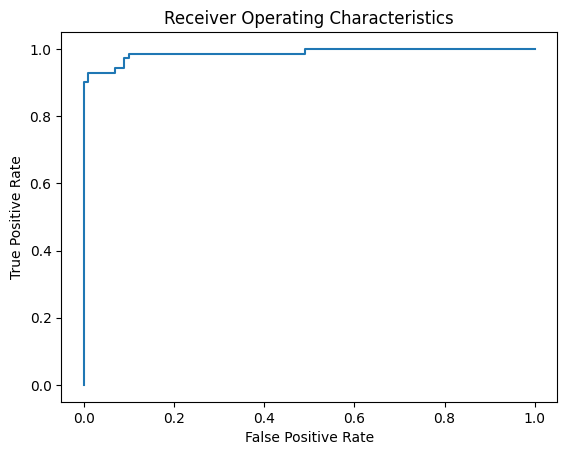

In [ ]:
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

#### With using PCA

In [ ]:
data = pd.read_csv('/content/Cancer_Data.csv')

# transform to binary
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
print(encoder.classes_)

In [ ]:
pca(data) # ???

In [ ]:
columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns_to_drop, axis=1, inplace=True)

X = data.drop('diagnosis', axis=1)
y = data.diagnosis
